### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [122]:
import numpy as np
import pandas as pd


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import catboost as ctb

# from catboost import Pool, cv

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix


import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

In [123]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

C:\Users\Energizer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [124]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

C:\Users\ENERGI~1\AppData\Local\Temp/ipykernel_19840/3802500363.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [125]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [126]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [127]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [128]:
%script_false
# LogisticRegression
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

UsageError: Line magic function `%script_false` not found.


In [143]:
# GradientBoostingClassifier
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.8025125910838183+-0.00707472977074522


In [130]:
%script_false
# RandomForestClassifier
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

UsageError: Line magic function `%script_false` not found.


In [131]:
%script_false
# CatBoostClassifier
classifier = Pipeline([
    ('features',feats),
    ('classifier', ctb.CatBoostClassifier(silent=True, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.8022220426159614+-0.00728146158484574


Посчитаем precision/recall/f_score

In [144]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

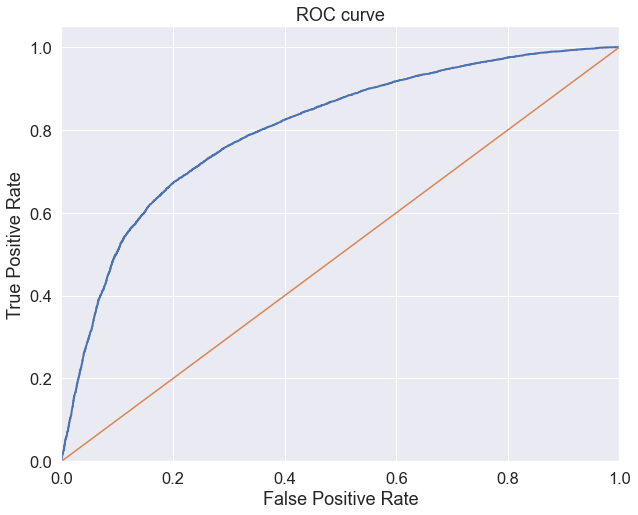

In [145]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [146]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.8026153641179974
log loss score: 0.5397460438742135


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


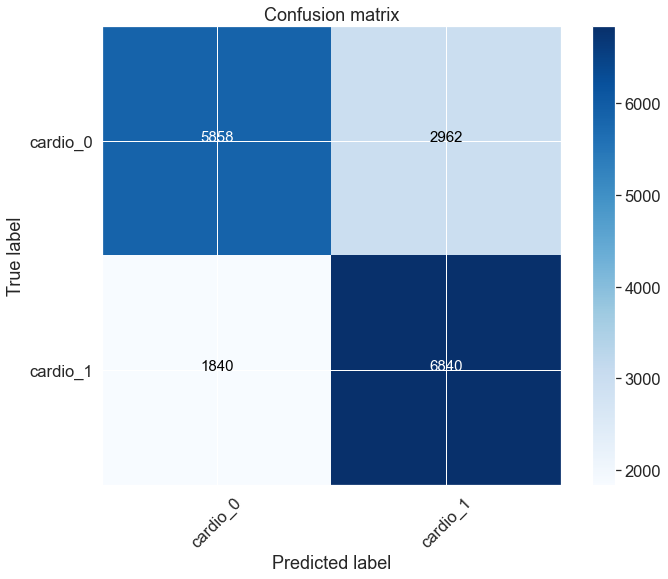

In [147]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [156]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7880184331797235, 0.33582766439909295, 0.664172335600907)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

**Комментарий** Этот вывод из FPR не очень корректен, правильнее будет так - 45% пациентов, получивших метку 1, на самом деле будут здоровы.

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

**Задание 1-2**

**LogisticRegression:**
- CV score is 0.7867401104915408+-0.00852135511666111
- Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838
- roc auc score: 0.7840347790421852
- log loss score: 0.5779604008230665
- TPR, FPR, TNR: 0.837442396313364, 0.44886621315192743, 0.5511337868480726

**GradientBoostingClassifier:**
- CV score is 0.8025125910838183+-0.00707472977074522
- Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788
- roc auc score: 0.8026153641179974
- log loss score: 0.5397460438742135
- TPR, FPR, TNR: 0.7880184331797235, 0.33582766439909295, 0.664172335600907

**RandomForestClassifier:**
- CV score is 0.7734501681056019+-0.007171140345435727
- Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816
- roc auc score: 0.7710366181802983
- log loss score: 0.5992984853728378
- TPR, FPR, TNR: 0.8084101382488479, 0.43412698412698414, 0.5658730158730159

**CatBoostClassifier:**
- CV score is 0.8022220426159614+-0.00728146158484574
- Best Threshold=0.382575, F-Score=0.739, Precision=0.689, Recall=0.797
- roc auc score: 0.801387478186359
- log loss score: 0.5413411356692721
- TPR, FPR, TNR: 0.7973502304147465, 0.3538548752834467, 0.6461451247165533

**Задание 3**

In [140]:
cols = ["Model", "CV score",
        "Threshold",
        "F-Score",
        "Precision",
        "Recall",
        "roc_auc_score",
        "log_loss_score",
        "TPR",
        "FPR",
        "TNR"]

data = [["LogisticRegression", 0.7867401104915408, 0.386937, 0.730, 0.647, 0.838, 0.7840347790421852, 0.5779604008230665, 0.837442396313364, 0.44886621315192743, 0.5511337868480726],
         ["GradientBoostingClassifier", 0.8025125910838183, 0.394947, 0.740, 0.698, 0.788, 0.8026153641179974, 0.5397460438742135, 0.7880184331797235, 0.33582766439909295, 0.664172335600907],
         ["RandomForestClassifier", 0.7734501681056019, 0.350000, 0.719, 0.643, 0.816, 0.7710366181802983, 0.5992984853728378, 0.8084101382488479, 0.43412698412698414, 0.5658730158730159],
         ["CatBoostClassifier", 0.8022220426159614, 0.382575, 0.739, 0.689, 0.797, 0.801387478186359, 0.5413411356692721, 0.7973502304147465, 0.3538548752834467, 0.6461451247165533]]

df = pd.DataFrame(data, columns=cols)
df

,Model,CV score,Threshold,F-Score,Precision,Recall,roc_auc_score,log_loss_score,TPR,FPR,TNR
0,LogisticRegression,0.786740,0.386937,0.730,0.647,0.838,0.784035,0.577960,0.837442,0.448866,0.551134
1,GradientBoostingClassifier,0.802513,0.394947,0.740,0.698,0.788,0.802615,0.539746,0.788018,0.335828,0.664172
2,RandomForestClassifier,0.773450,0.350000,0.719,0.643,0.816,0.771037,0.599298,0.808410,0.434127,0.565873
3,CatBoostClassifier,0.802222,0.382575,0.739,0.689,0.797,0.801387,0.541341,0.797350,0.353855,0.646145


In [141]:
# Лучший результат по roc_auc
df.loc[df['roc_auc_score'] == df['roc_auc_score'].max()]

,Model,CV score,Threshold,F-Score,Precision,Recall,roc_auc_score,log_loss_score,TPR,FPR,TNR
1,GradientBoostingClassifier,0.802513,0.394947,0.74,0.698,0.788,0.802615,0.539746,0.788018,0.335828,0.664172


In [142]:
# Лучший результат по F-score
df.loc[df['F-Score'] == df['F-Score'].max()]

,Model,CV score,Threshold,F-Score,Precision,Recall,roc_auc_score,log_loss_score,TPR,FPR,TNR
1,GradientBoostingClassifier,0.802513,0.394947,0.74,0.698,0.788,0.802615,0.539746,0.788018,0.335828,0.664172


**Задание 4**

При одинаковых базовых настройках моделей наилучние результаты по основным показателям среди всех моделей показал градиентный бустинг:
- Основные метрики F-score и roc_auc у данной модели выше всех
- Самый высокий показатель точности определения здоровых людей TNR=66%

Однако точность выявления заболевания при этом самая худшая - TPR=79%%, но при этом "всего" около 34% пациентов, получивших метку 1, на самом деле будут здоровы. И, если нам наиболее важно выявить как можно больше заболевших людей, т.е. минимизировать ошибку 2го рода, то с этой задачей лучше всех справилась исходная модель логистической регрессии.

**Задание 5**

1я модель лучше т.к. во втором случае ошибка 1го рода, т.е. FP=910, что дает разницу в precision у моделей 0,9 в 1м случае против 0,09 во втором. В данном случае по TPR и FPR моделей также видно, что 1я модель лучше, но в целом, roc_auc не устойчив к несбалансированным данным. Когда количество положительных объектов в выборке в разы меньше отрицательных FPR будет очень низок и с у величением разницы будет стремиться к 0 (т.к. увеличивается TN) и площадь под кривой будет стремиться к 1, поэтому в таком варианте лучше использовать PR-кривую.